# Wikipedia clickstream dataset

This notebook analyzes the February 2016 Wikipedia clickstream dataset. The following references are useful to get the data and understand how it is structured.

- <https://dx.doi.org/10.6084/m9.figshare.1305770.v16>
- <http://ewulczyn.github.io/Wikipedia_Clickstream_Getting_Started/>

In [1]:
%matplotlib inline

In [2]:
import choix
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle

from scipy.stats import entropy
from thesis.choicerank import displacement, weighted_quantiles, qtod

## Processing the raw data

In [3]:
%%time
graph = nx.DiGraph()
tot_count = 0
with open("data/2016_03_clickstream.tsv") as f:
    next(f)  # First line is header.
    for line in f:
        prev_title, curr_title, kind, n = line.split("\t")
        tot_count += int(n)
        if kind.strip() == "link":
            graph.add_edge(prev_title, curr_title, traffic=int(n))
graph = nx.convert_node_labels_to_integers(graph, label_attribute="article")
print("done (total traffic: {:,})".format(tot_count))

for v in graph.nodes:
    graph.nodes[v]["in"] = 0
    graph.nodes[v]["out"] = 0

for src, dst, traff in graph.edges(data="traffic"):
    graph.nodes[src]["out"] += traff
    graph.nodes[dst]["in"] += traff

done (total traffic: 6,815,240,857)
CPU times: user 4min 28s, sys: 33.1 s, total: 5min 1s
Wall time: 5min 12s


In [4]:
inflow = np.array(list(graph.nodes[v]["in"] for v in graph), dtype=float)
outflow = np.array(list(graph.nodes[v]["out"] for v in graph), dtype=float)

In [5]:
print("{:,} nodes, {:,} edges".format(len(graph), len(graph.edges())))
print("inflow: {:,} outflow: {:,}".format(int(inflow.sum()), int(outflow.sum())))

2,316,032 nodes, 13,181,698 edges
inflow: 1,225,246,602 outflow: 1,225,246,602


## Estimating transition probabilities

We compare ChoiceRank to three baselines (traffic, pagerank, uniform) against the observed (ground-truth) transition counts.
We use two metrics:

- the KL-divergence
- the average displacement (ranking metric)

Running ChoiceRank.

In [6]:
%%time
# /!\ Beware, `alpha` here corresponds to α - 1 in the thesis.
thetas = choix.choicerank(graph, inflow, outflow, alpha=1.0, tol=1e-08, max_iter=10000)
crs = np.exp(thetas)

CPU times: user 7min 22s, sys: 1min 36s, total: 8min 59s
Wall time: 9min 6s


Running PageRank.

In [7]:
%%time
pr = nx.pagerank_scipy(graph, weight=None)
prs = np.array(list(pr[v] for v in graph), dtype=float)

CPU times: user 1min 35s, sys: 1.46 s, total: 1min 37s
Wall time: 1min 37s


Compute accuracy w.r.t. ground-truth.

In [8]:
%%time
methods = ["crnk", "traf", "prnk", "unif"]
kls = {m: list() for m in methods}
dps = {m: list() for m in methods}
ws = list()

# Aggregating performance by out-degree.
kls_by_deg = {m: collections.defaultdict(lambda: 0) for m in methods}
ws_by_deg = collections.defaultdict(lambda: 0)

for v in list(graph):
    if v % 100000 == 0:
        print("{:02d}".format(v // 100000), end=" ", flush=True)
    succs = list(graph.successors(v))
    deg = len(succs)
    weight = graph.nodes[v]["out"]
    if len(succs) < 2:
        continue
    ps = np.zeros(len(succs))
    qs = {m: np.zeros(len(succs)) for m in methods}
    for i, s in enumerate(succs):
        ps[i] = graph.edges[v,s]["traffic"]
        qs["crnk"][i] = crs[s]
        qs["traf"][i] = graph.nodes[s]["in"]
        qs["prnk"][i] = prs[s]
        qs["unif"][i] = 1.0
    ps = ps / np.sum(ps)
    for m in methods:
        qs[m] = qs[m] / np.sum(qs[m])
        kls[m].append(entropy(ps, qs[m]))
        kls_by_deg[m][deg] += weight * entropy(ps, qs[m])
        dps[m].append(displacement(qs[m], ps) / len(succs)**2)
    ws.append(weight)
    ws_by_deg[deg] += weight
print("done.")

00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 done.
CPU times: user 9min 54s, sys: 1.09 s, total: 9min 55s
Wall time: 9min 55s


In [9]:
kls = {m: np.array(kls[m]) for m in methods}
dps = {m: np.array(dps[m]) for m in methods}

## Plotting the weighted accuracy

In [10]:
fractions = [0.05, 0.25, 0.5, 0.75, 0.95]
kls2 = dict()
dps2 = dict()

for m in methods:
    kls2[m] = qtod(zip(fractions, weighted_quantiles(kls[m], ws, fractions=fractions)))
    dps2[m] = qtod(zip(fractions, weighted_quantiles(dps[m], ws, fractions=fractions)))

Text(0.5,1,'Displacement')

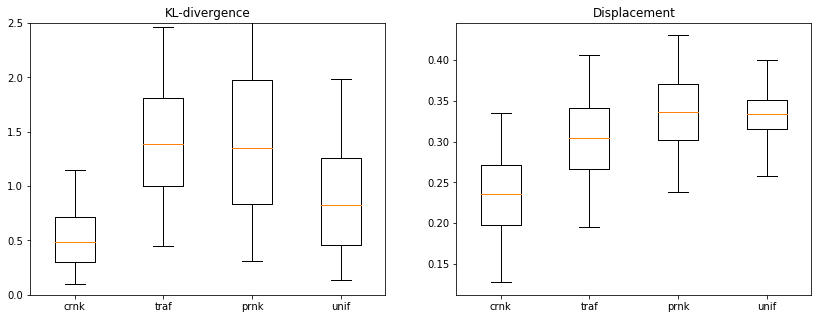

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14.0, 5.0))
# KL-divergence.
axs[0].boxplot(list(kls2[m] for m in methods), labels=methods, whis=[5, 95])
axs[0].set_title("KL-divergence")
axs[0].set_ylim([0,2.5])
# Displacement
axs[1].boxplot(list(dps2[m] for m in methods), labels=methods, whis=[5, 95])
axs[1].set_title("Displacement")

## Save data for further usage

In [ ]:
for m in methods:
    kls_by_deg[m] = dict(kls_by_deg[m])
ws_by_deg = dict(ws_by_deg)

data = {
    "kls": kls,
    "dps": dps,
    "ws": ws,
    "kls-by-deg": kls_by_deg,
    "ws-by-deg": ws_by_deg,
}
with open("data/wpclk-201603.pickle", "wb") as f:
    pickle.dump(data, f)